<a href="https://colab.research.google.com/github/guscldns/TestProject/blob/main/0727/08_basic_semantic_segmentation(Unet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# basic semantic segmentation(Unet)

## Segmentation Dataset 설명

https://www.robots.ox.ac.uk/~vgg/data/pets/

- 대략 200개, 37개 범주의 애완 동물 데이터 세트
- a large variations in scale, pose and lighting
- annotation : 견종, head ROI, pixel level segment

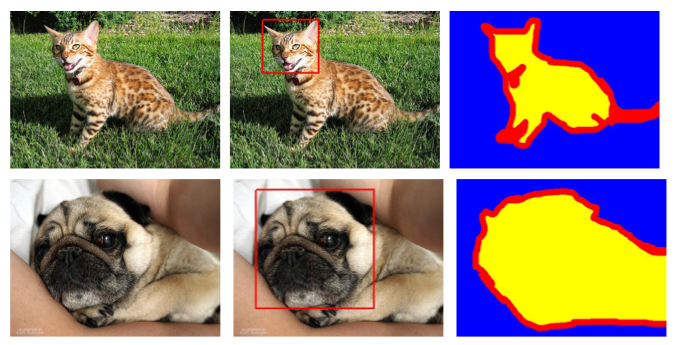

In [1]:
!pip install keras-unet-collection

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 1.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import random
from IPython.display import Image, display

import cv2
from PIL import ImageOps

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input, Conv2D, Dropout, Activation, UpSampling2D, GlobalMaxPooling2D, multiply
from tensorflow.keras.backend import max
from tensorflow.python.client import device_lib

from keras_unet_collection import models, base, utils

## 0) Set Memory_limit

In [3]:
# 메모리 용량을 초과하지 않도록 하여 메모리 부족을 방지하기 위한 설정

for dev in device_lib.list_local_devices(): # 사용가능한 device(CPU, GPU 등) 목록
    print(dev.device_type, dev.memory_limit)
gpu_max_mem = float(device_lib.list_local_devices()[0].memory_limit)
gpu_mem_limit = 12

# GPUOptions : mem limit 등 GPU option 설정
# per_process_gpu_memory_fraction : 사용 가능한 GPU 메모리의 비율 지정
memory_frac = 1024*1024*1024*gpu_mem_limit/gpu_max_mem
config = tf.compat.v1.ConfigProto(
    gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=memory_frac)
    )
sess = tf.compat.v1.Session(config=config)

CPU 268435456
GPU 14328594432


## 1) Download Oxford Pet Data

In [4]:
# image data
!gdown 1dol8eJfAFPqSYKXND8_eXMevohpyEyMP

Downloading...
From: https://drive.google.com/uc?id=1dol8eJfAFPqSYKXND8_eXMevohpyEyMP
To: /content/images.tar.gz
100% 792M/792M [00:05<00:00, 133MB/s]


In [5]:
# annotation data
!gdown 1Kst2nBmsoUVdSRMeuesakLFRqGCGjPJx

Downloading...
From: https://drive.google.com/uc?id=1Kst2nBmsoUVdSRMeuesakLFRqGCGjPJx
To: /content/annotations.tar.gz
100% 19.2M/19.2M [00:00<00:00, 146MB/s]


In [6]:
!tar -xf images.tar.gz

In [7]:
!tar -xf annotations.tar.gz

## 2) EDA

- Trimap :
    1. Foreground - white,  
    2. Background - black,
    3. Transition - gray
- xml : Head bbox annotations in PASCAL VOC Format
- list.txt : all images info in the dataset
    1. img filename
    2. ID : 37 CLASS ID
    3. SPECIES : 1(CAT), 2(DOG)
    4. BREED : 1-25(CAT), 1-12(DOG)

In [8]:
## list.txt 파일 확인
df_annot = pd.read_csv('annotations/list.txt', delimiter=' ', skiprows=6, header=None)
df_annot.columns = ['OBJECT', 'ID', 'SPECIES', 'BREED']
display(df_annot.head())
display(df_annot.tail())

,OBJECT,ID,SPECIES,BREED
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


,OBJECT,ID,SPECIES,BREED
7344,yorkshire_terrier_96,37,2,25
7345,yorkshire_terrier_97,37,2,25
7346,yorkshire_terrier_98,37,2,25
7347,yorkshire_terrier_99,37,2,25
7348,yorkshire_terrier_9,37,2,25


In [9]:
df_by_id = df_annot[['OBJECT', 'ID']].groupby('ID').count()
display(df_by_id.T)

ID,1,2,3,4,5,6,7,8,9,10,...,28,29,30,31,32,33,34,35,36,37
OBJECT,198,200,200,200,200,200,200,184,199,200,...,200,200,200,199,200,199,200,189,200,200


<Axes: xlabel='ID'>

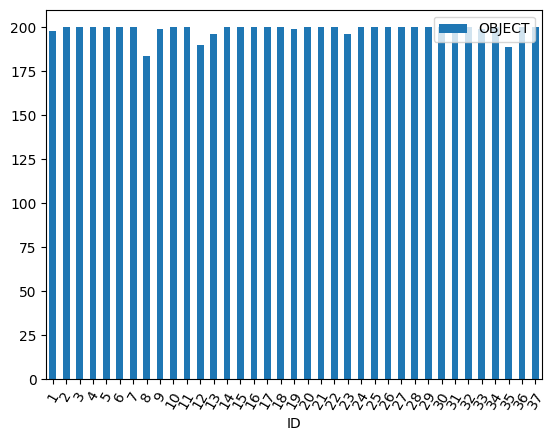

In [10]:
df_by_id.plot.bar(rot=60)

In [11]:
df_by_species = df_annot[['OBJECT', 'SPECIES']].groupby('SPECIES').count()
display(df_by_species.T)

SPECIES,1,2
OBJECT,2371,4978


<Axes: xlabel='SPECIES'>

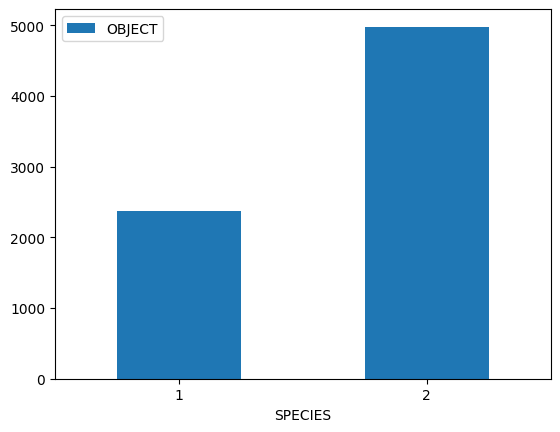

In [12]:
df_by_species.plot.bar(rot=0)

In [13]:
df_by_breed = df_annot[['OBJECT', 'BREED']].groupby('BREED').count()
display(df_by_breed.T)

BREED,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
OBJECT,398,400,400,384,399,390,396,400,400,400,...,196,200,200,200,200,199,200,189,200,200


<Axes: xlabel='BREED'>

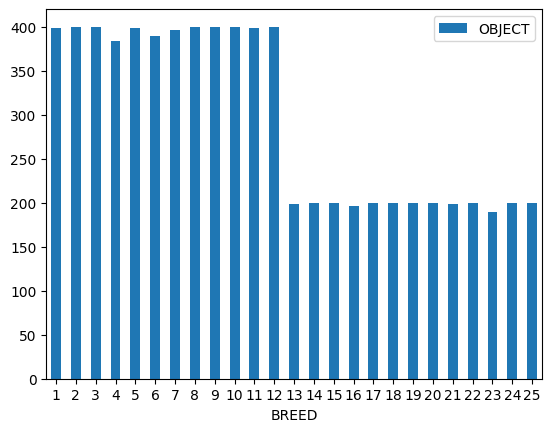

In [14]:
df_by_breed.plot.bar(rot=0)

In [15]:
df_by_sb = df_annot[['OBJECT', 'SPECIES', 'BREED']].groupby(['SPECIES','BREED']).count()
df_by_sb.T

SPECIES    1                                               ...    2            \
BREED     1    2    3    4    5    6    7    8    9    10  ...   16   17   18   
OBJECT   198  200  200  184  200  190  200  200  200  200  ...  196  200  200   

SPECIES                                     
BREED     19   20   21   22   23   24   25  
OBJECT   200  200  199  200  189  200  200  

[1 rows x 37 columns]

In [16]:
## 이미지 데이터 path 지정
input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (128, 128)
num_classes = 3
batch_size = 32

input_img_paths = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir)
                                                            if fname[-3:] == "jpg"])
target_img_paths = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir)
                                                            if fname[-3:] == "png" and fname[0] !="."])

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:3], target_img_paths[:3]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png


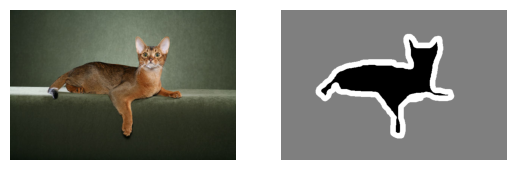

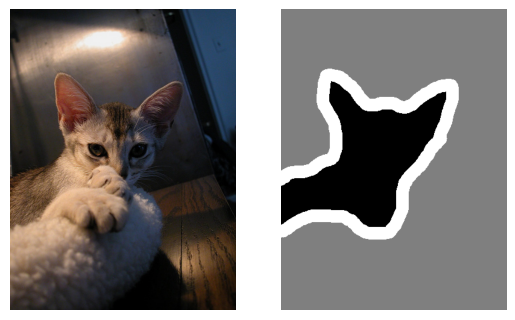

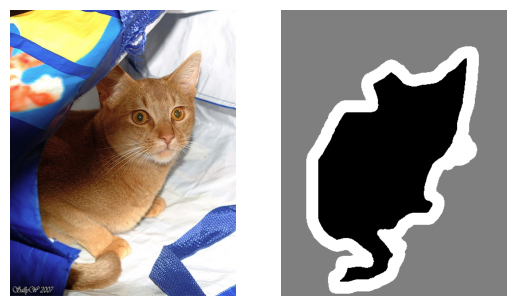

In [17]:
## 학습 데이터 확인
for img_idx in range(3):
    ori_img = image.load_img(input_img_paths[img_idx])
    target_img = ImageOps.autocontrast(image.load_img(target_img_paths[img_idx]))

    plt.subplot(1,2,1)
    plt.axis("off")
    plt.imshow(ori_img)

    plt.subplot(1,2,2)
    plt.axis("off")
    plt.imshow(target_img, vmax = 3, vmin = 0)
    plt.show()

## 3) Set DataLoader

In [ ]:
class OxfordPetDataset(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths


    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size

        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = image.load_img(path, target_size=self.img_size)
            x[j] = img

        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = image.load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)

            # target data에 있는 라벨인 1, 2, 3 에서 1을 빼서 0, 1, 2 로 변경
            y[j] -= 1
        return x, y


## 4) Preparation Dataset with DataLoader

In [ ]:
# train, val split
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]

val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

train_gen = OxfordPetDataset(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = OxfordPetDataset(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## 5) Modeling

In [ ]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

model = models.unet_2d((None, None, 3), [64, 128, 256, 512], n_labels=3,
                      stack_num_down=2, stack_num_up=2,
                      activation='ReLU', output_activation='Softmax',
                      batch_norm=True, pool='max', unpool='nearest', name='unet')
model.summary()

Model: "unet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 unet_down0_0 (Conv2D)          (None, None, None,   1728        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 unet_down0_0_bn (BatchNormaliz  (None, None, None,   256        ['unet_down0_0[0][0]']           
 ation)                         64)                                                      

## 6) Train

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

with tf.device("/device:GPU:0"):
    history = model.fit(train_gen, epochs=10, validation_data=val_gen, verbose=1)

Epoch 1/10
199/199 [==============================] - 93s 411ms/step - loss: 0.6380 - val_loss: 1.1024
Epoch 2/10
199/199 [==============================] - 78s 389ms/step - loss: 0.4446 - val_loss: 0.6061
Epoch 3/10
199/199 [==============================] - 77s 388ms/step - loss: 0.3794 - val_loss: 0.4562
Epoch 4/10
199/199 [==============================] - 78s 390ms/step - loss: 0.3436 - val_loss: 0.4888
Epoch 5/10
199/199 [==============================] - 77s 386ms/step - loss: 0.3165 - val_loss: 0.4119
Epoch 6/10
199/199 [==============================] - 77s 387ms/step - loss: 0.3025 - val_loss: 0.5232
Epoch 7/10
199/199 [==============================] - 82s 413ms/step - loss: 0.2841 - val_loss: 0.3348
Epoch 8/10
199/199 [==============================] - 77s 388ms/step - loss: 0.2663 - val_loss: 0.3234
Epoch 9/10
199/199 [==============================] - 77s 387ms/step - loss: 0.2568 - val_loss: 0.3682
Epoch 10/10
199/199 [==============================] - 77s 387ms/step - l

## 7) Inference

In [ ]:
val_preds = model.predict(val_gen)
print(len(val_preds), val_preds[0].shape)

31/31 [==============================] - 6s 197ms/step
992 (128, 128, 3)


In [ ]:
color_map = {
 '0': [255, 0, 0],
 '1': [0, 0, 0],
 '2': [255, 255, 255],
}

def resize_mask(img, target_size):
    mask = np.argmax(img, axis=-1)
    mask = tf.expand_dims(mask, axis=-1).numpy().astype(float)
    return cv2.resize(mask, dsize=target_size, interpolation=cv2.INTER_NEAREST)

def add_mask_to_img(input_img, mask, alpha = 0.6):
    img_color = image.img_to_array(input_img)
    img = image.img_to_array(input_img)

    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            img_color[i, j] = color_map[str(int(mask[i, j]))]

    alpha = 0.6
    img = cv2.addWeighted(img, alpha, img_color, 1-alpha, 0, img_color, dtype = cv2.CV_32F)
    return img

def ero_dil(im, filter_size = 5):
    se = cv2.getStructuringElement(cv2.MORPH_RECT, (filter_size, filter_size))
    im = cv2.dilate(im, se) #팽창
    im = cv2.erode(im, se) #침식

    return im

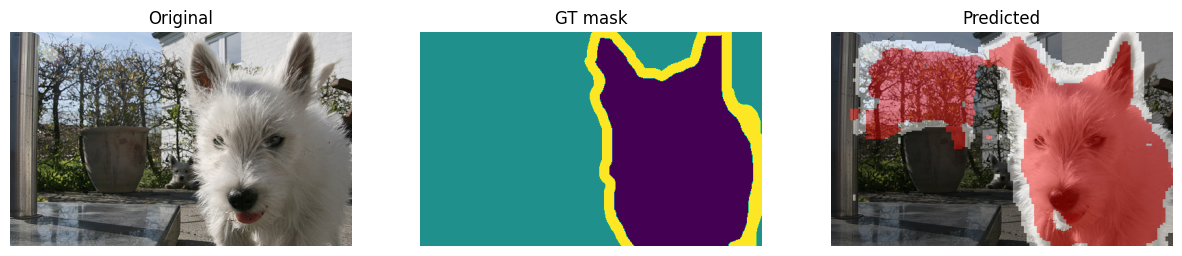

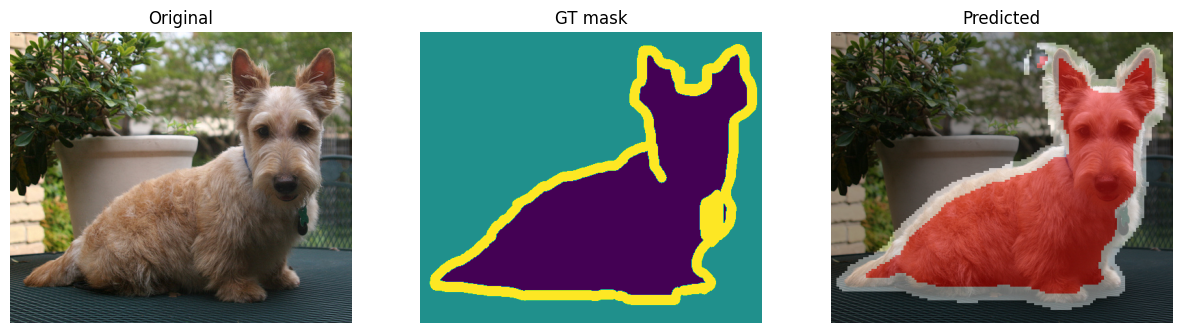

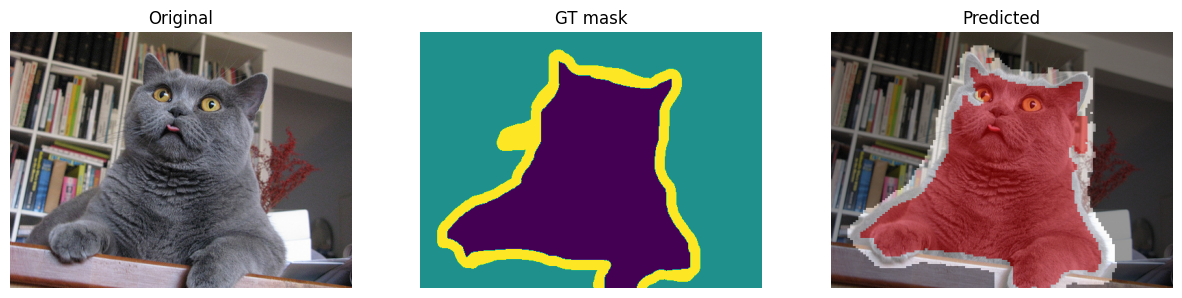

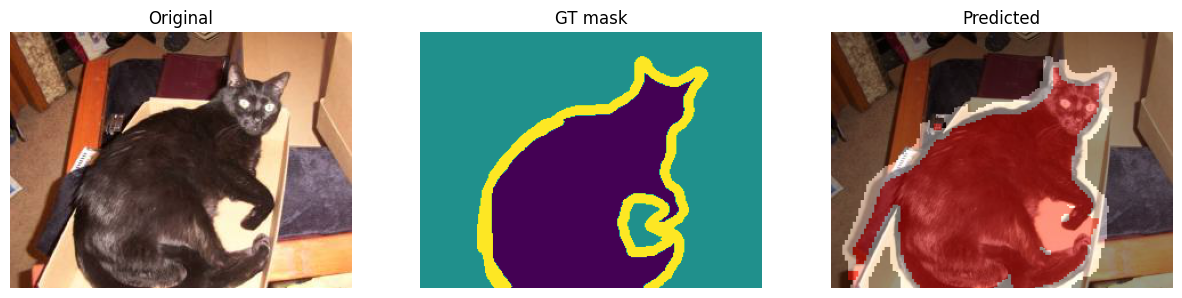

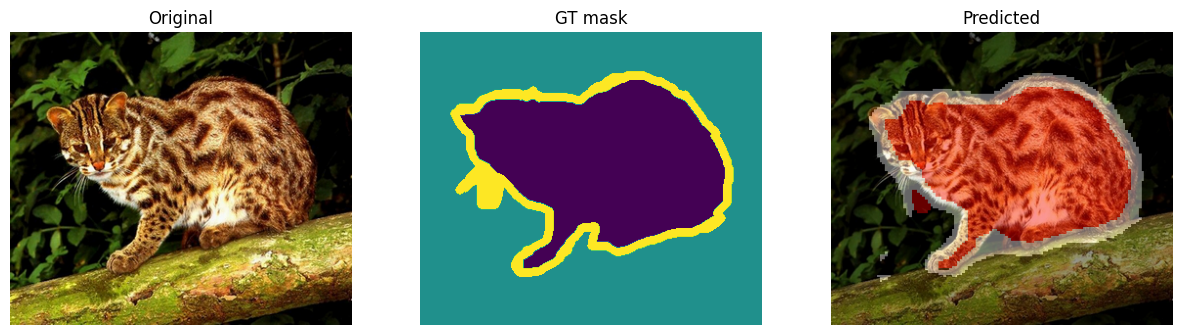

In [ ]:
for img_idx in random.sample(list(range(len(val_preds))), 5):
    plt.figure(figsize=(15,8))

    ori_img = image.load_img(val_input_img_paths[img_idx])
    target_img = image.load_img(val_target_img_paths[img_idx])
    target_mask = image.img_to_array(target_img)[:,:,0] - 1

    mask = val_preds[img_idx]

    plt.subplot(1,3,1)
    plt.title('Original')
    plt.axis("off")
    plt.imshow(ori_img)

    plt.subplot(1,3,2)
    plt.title('GT mask')
    plt.axis("off")
    plt.imshow(target_mask)

    resized_mask = resize_mask(mask, ori_img.size)
    masked_img = add_mask_to_img(ori_img, resized_mask)

    plt.subplot(1,3,3)
    plt.title('Predicted')
    plt.axis("off")
    processed_mask = ero_dil(resized_mask)
    masked_img = add_mask_to_img(ori_img, processed_mask)
    plt.imshow(image.array_to_img(masked_img))

    plt.show()

## 8) Result Visualization

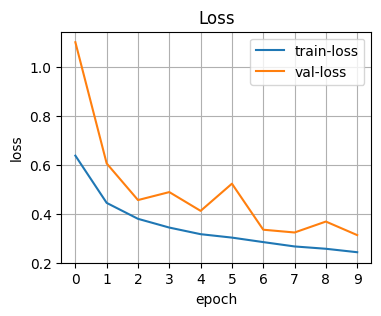

In [ ]:
history_unet = history.history

plt.figure(figsize=(4, 3))
plt.plot(history_unet['loss'], label='train-loss')
plt.plot(history_unet['val_loss'], label='val-loss')
plt.legend()
plt.grid()
plt.xticks(range(10))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")
plt.show()